This notebook provides some examples on how to interact programmatically with the `MFLike` likelihood.



## Preamble



In [48]:
%matplotlib inline
import os
import tempfile

import camb
import cobaya
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

print("     Numpy :", np.__version__)
print("Matplotlib :", mpl.__version__)
print("      CAMB :", camb.__version__)
print("    Cobaya :", cobaya.__version__)

     Numpy : 1.20.2
Matplotlib : 3.3.3
      CAMB : 1.3.2
    Cobaya : 3.1.0


## Loading & getting the MFLike likelihood from cobaya



We first set the default values of CMB, foreground and nuisance parameters



In [49]:
cosmo_params = {
    "cosmomc_theta": 1.0406190e-02,
    "logA": {"value": 3.0579842e+00, "drop": True},
    "As": {"value": "lambda logA: 1e-10*np.exp(logA)"},
    "ombh2": 2.2178638e-02,
    "omch2": 1.2130776e-01,
    "ns": 9.6228792e-01,
    "Alens": 1.0,
    "tau": 5.8906896e-02,
}

fg_params = {"a_tSZ": 3.30, 
             "a_kSZ": 1.60, 
             "a_p": 6.90, 
             "beta_p": 2.08,
             "a_c": 4.90,
             "beta_c": 2.20,
             "a_s": 3.10,
             "T_d": 9.60,    
             "a_gtt": 2.819845541,
             "a_gte": 0.081234536,
             "a_gee": 0.063235678,
             "a_psee": 0.003123453,
             "a_pste": 0.042312344,
             "xi": 0.03,}

nuisance_params = {"bandint_shift_93": 0,     #only ideal values for now
                   "bandint_shift_145": 0,
                   "bandint_shift_225": 0,
                   "calT_93": 1,
                   "calE_93": 1,
                   "calT_145": 1,
                   "calE_145": 1,
                   "calT_225": 1,
                   "calE_225": 1,
                   "calG_all": 1,
                   "alpha_93": 0,
                   "alpha_145": 0,
                   "alpha_225": 0}

Then we declare our likelihood



In [50]:
mflike_config = {
    "mflike.MFLike": {
        "input_file": "data_sacc_00044.fits",
        "cov_Bbl_file": "data_sacc_w_covar_and_Bbl.fits",
        "band_integration": {
            "external_bandpass": False,
            "nsteps" : 1,       #no band integration with these settings
            "bandwidth": 0},
        "systematics_template": {
          "has_file": False,     #set to True to add systematic template
          "rootname": "test_template"},
        "lmax_theory": 9000,     #value up to which camb spectra are computed
        }
}

We will need to download and install [`LAT_MFLike_data`](https://github.com/simonsobs/LAT_MFLike_data). Here we will do it programatically in such a
way we can use this notebook without any prerequisites. Code and data will be stored in the `/tmp`
directory for the tutorial purpose but feel free to change it to whatever location you want. By the
way the next command will take some times to proceed



In [54]:
from cobaya.install import install

packages_path = os.path.join(tempfile.gettempdir(), "LAT_packages")
install({"likelihood": mflike_config}, path=packages_path, skip_global=True)

[install] Installing external packages at '/tmp/LAT_packages'

likelihood:mflike.MFLike

[install] Checking if dependencies have already been installed...
[install] External dependencies for this component already installed.
[install] Doing nothing.

* Summary * 

[install] All requested components' dependencies correctly installed.
[install] The installation path has been written into the global config file: /home/sgiardie/.config/cobaya/config.yaml


We finally put everything into a dictionary to push it into `cobaya` configuration system



In [55]:
info = {
    "params": {**cosmo_params, **fg_params,**nuisance_params},
    "likelihood": mflike_config,
    "theory": {"camb": {"extra_args": {"lens_potential_accuracy": 1}}},
    "packages_path": packages_path,
}

We will now get the model given the above parameters



In [56]:
from cobaya.model import get_model

model = get_model(info)

[CAMB] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[mflike.mflike] Initialized!


To get a direct acces to the `MFLike` likelihood instance, we can retrieve it from the collection of
likelihoods of `cobaya` given its name (so far there is only our likelihood)



In [57]:
mflike = model.likelihood["mflike.MFLike"]

We can now play with the different data (Bbl, inverted covariance matrix) and we can also call the
different methods such as `_get_foreground_model` to see what foreground model look likes.



## Getting likelihood value given current parameter set



We can retrieve informations related to likelihood(s) as follow



In [58]:
loglikes, derived = model.loglikes({})
print("log-likelihood value = {}, derived parameter value (As) = {}".format(loglikes, derived))

log-likelihood value = [-8110.90418573], derived parameter value (As) = [2.1284608374925558e-09]


We can also use the `evaluate` sampler that evaluates the log-likelihood at a given reference point :
here, since parameters are all fixed, it computes the log-likelihood value.



In [59]:
from cobaya.run import run

info["sampler"] = {"evaluate": None}
updated_info, products = run(info)

[CAMB] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[mflike.mflike] Initialized!
[evaluate] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
[evaluate] Initialized!
[evaluate] Looking for a reference point with non-zero prior.
[evaluate] Reference point:
   
[evaluate] Evaluating prior and likelihoods...
[evaluate] log-posterior  = -8110.9
[evaluate] log-prior      = 0
[evaluate]    logprior_0 = 0
[evaluate] log-likelihood = -8110.9
[evaluate]    chi2_mflike.MFLike = 16221.8
[evaluate] Derived params:
[evaluate]    As = 2.12846e-09


Finally, we can directly catch the value returned by `logp` function from `MFLike` likelihood



In [60]:
logp = mflike.logp(**fg_params,**nuisance_params)
print("log-likelihood value =", logp)
print("Χ² value =", -2 * (logp - mflike.logp_const))

log-likelihood value = -8110.904185733497
Χ² value = 15841.4752586473


## Plotting CMB power spectra



Here we get $C_\ell$ for different mode for and the same range of [&ell;<sub>min</sub>;&ell;<sub>max</sub>] as the
default range of `MFLike`. To get a different range, change the `lmax_theory` value in `mflike_config`. Make sure to call the `model.logposterior` line with the `cached=False`
option in order to recompute $C_\ell$s given the new &ell; range.



In [61]:
lmin, lmax = 2, mflike.lmax_theory
Cl = {"tt": lmax, "ee": lmax, "te": lmax, "bb": lmax}
model.theory["camb"].must_provide(Cl=Cl)
model.logposterior({})
Dls = model.theory["camb"].get_Cl(ell_factor=True)

Let's plot the different spectra



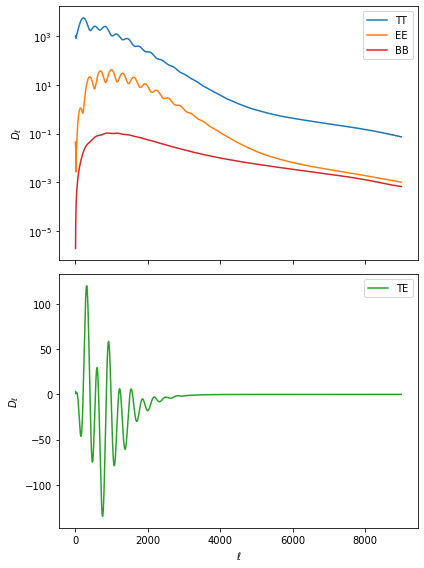

In [62]:
ell = np.arange(lmin, lmax)
dls = {cl: Dls[cl][ell] for cl in Cl.keys()}
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(6, 8))
axes[0].set_yscale("log")
for i, cl in enumerate(Cl.keys()):
    ax = axes[1] if cl == "te" else axes[0]
    ax.plot(ell, dls[cl], "-C{}".format(i), label=cl.upper())

for ax in axes:
    ax.set_ylabel(r"$D_\ell$")
    ax.legend()
    axes[1].set_xlabel(r"$\ell$")
    plt.tight_layout()

## Plotting foregrounds



Get all the foreground models with the `_get_foreground_model` in `theoryforge.py`. In principle, we can generate a foreground model at higher &ell; than the theory through the `ell` argument; here we keep the same &ell; range to plot the foregrounds with the theory in the next cell.



In [63]:
fg_models = mflike.ThFo._get_foreground_model(ell=ell,**fg_params)

Then plot theory and foregrounds in a triangle plot



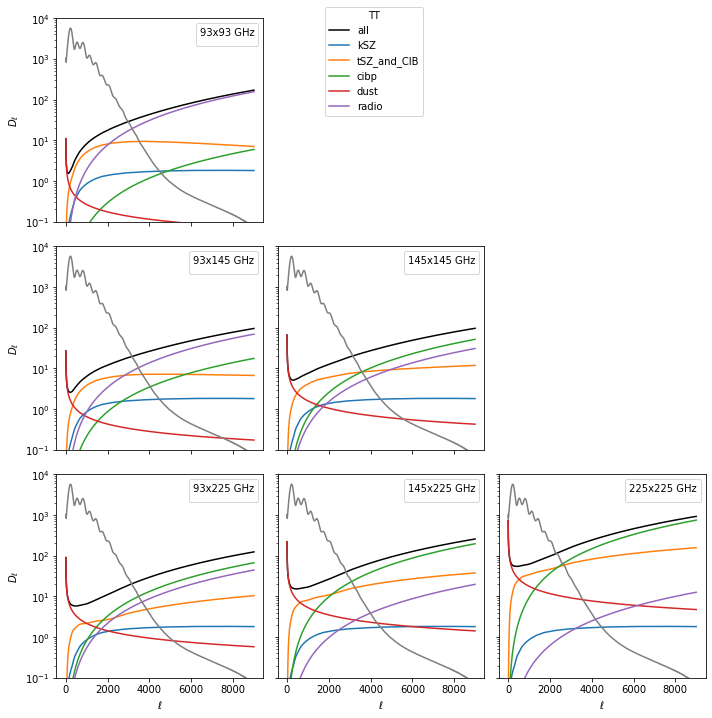

In [64]:
mode = "tt"
components = mflike.foregrounds["components"][mode]
freqs = sorted(mflike.freqs)
nfreqs = len(freqs)
fig, axes = plt.subplots(nfreqs, nfreqs, sharex=True, sharey=True, figsize=(10, 10))
from itertools import product

for i, cross in enumerate(product(freqs, freqs)):
    idx = (i % nfreqs, i // nfreqs)
    ax = axes[idx]
    if idx in zip(*np.triu_indices(nfreqs, k=1)):
        fig.delaxes(ax)
        continue
    ax.plot(ell, fg_models[mode, "all", cross[0], cross[1]], color="k")
    for compo in components:
        ax.plot(ell, fg_models[mode, compo, cross[0], cross[1]])
    ax.plot(ell, dls[mode], color="tab:gray")
    ax.legend([], title="{}x{} GHz".format(*cross))
    if mode == "tt":
        ax.set_yscale("log")
        ax.set_ylim(10 ** -1, 10 ** 4)

for i in range(nfreqs):
    axes[-1, i].set_xlabel("$\ell$")
    axes[i, 0].set_ylabel("$D_\ell$")
fig.legend(["all"] + components, title=mode.upper(), bbox_to_anchor=(0.6, 1))
plt.tight_layout()

we can also plot the 'ee' or 'te' fields by changing `mode` in the previous cell, to see the contribution from radio and dust components

## Plotting simulations & residuals



Simulations and covariance are stored as `sacc` objects. Here we will read the power spectra for all
the simulations and compare its mean value to theory + foregrounds (without and with systematics). For more details regarding `sacc`
format, you can have a look to the tutorial [notebooks](https://github.com/simonsobs/sacc/tree/master/examples) or you can refer to the official [documentation](https://sacc.readthedocs.io/en/latest/)

Here we define function utilities related to `sacc` files



In [65]:
import sacc

fn = os.path.join(mflike.data_folder, "data_sacc_w_covar_and_Bbl.fits")
s_b = sacc.Sacc.load_fits(fn)


def _get_tracers(spec, cross):
    spins = {"t": ("0", "s0"), "e": ("e", "s2"), "b": ("b", "s2")}
    if spec[1] == "t":
        data_type = "cl_{}{}".format(spins[spec[1]][0], spins[spec[0]][0])
    else:
        data_type = "cl_{}{}".format(spins[spec[0]][0], spins[spec[1]][0])
    tracers = ["LAT_{}_{}".format(cross[i], spins[spec[i]][1]) for i in range(2)]
    return data_type, tracers[0], tracers[1]


def read_sacc_data(spec, cross, sim_id):
    fn = os.path.join(mflike.data_folder, "data_sacc_{:05d}.fits".format(sim_id))
    s = sacc.Sacc.load_fits(fn)
    return s.get_ell_cl(*_get_tracers(spec, cross))


def read_sacc_cov(spec, cross):
    ell, cl, cov, ind = s_b.get_ell_cl(*_get_tracers(spec, cross), return_cov=True, return_ind=True)
    bpws = s_b.get_bandpower_windows(ind)
    return cov, bpws

We can plot unbinned theory + foreground model and the total power spectrum modified by the systematics with a bunch of simulated files. To take into account the systematics, we call the `mflike.ThFo.get_modified_theory` function. In this function, we need to use the same &ell; range set by the data through the variable `l_bpws`, so we cut the spectra generated by camb to the &ell;<sub>max</sub> of the data.



In [66]:
Dls_cmb = {}
for s in {'tt','te','ee','bb'}:
    Dls_cmb[s] = np.zeros_like(mflike.l_bpws)
    Dls_cmb[s] = dls[s][2:mflike.l_bpws[-1]+1]

In [67]:
dl_obs = mflike.ThFo.get_modified_theory(Dls_cmb,**fg_params,**nuisance_params)

There would be a difference between theory, foreground and the total spectra modified by the systematics once some of the `nuisance_parameters` are set to a non-ideal value

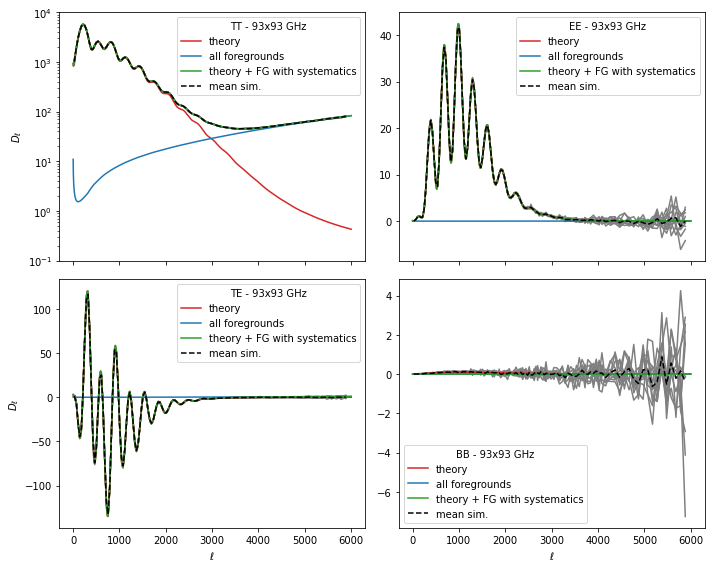

In [68]:
cross = (93, 93)
nsims = 10
ell = np.arange(2,mflike.l_bpws[-1]+1)
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(10, 8))
for spec, ax in zip(Cl.keys(), axes.flatten()):
    cls = []
    for i in range(nsims):
        cls += [read_sacc_data(spec, cross, i)]
        ax.plot(*cls[-1], color="tab:gray")
    ax.plot(ell, Dls_cmb[spec], color="tab:red", label="theory")
    fg = fg_models[spec, "all", cross[0], cross[1]][:mflike.l_bpws[-1]-1] if spec != "bb" else np.zeros_like(ell)
    ax.plot(ell, fg, color="tab:blue", label="all foregrounds")
    obs = dl_obs[(spec, cross[0], cross[1])] if spec != "bb" else np.zeros_like(ell)
    ax.plot(ell, obs, color="tab:green", lw = 1.5, label="theory + FG with systematics")
    ax.plot(*np.mean(cls, axis=0), "--k", label="mean sim.")
    ax.legend(title="{} - {}x{} GHz".format(spec.upper(), *cross))
    if spec == "tt":
        ax.set_yscale("log")
        ax.set_ylim(10 ** -1, 10 ** 4)

for ax in axes[:, 0]:
    ax.set_ylabel(r"$D_\ell$")
for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$")
plt.tight_layout()

We can also plot the residuals *i.e.* simulations - (theory + foregrounds with possible systematics) for the different spectra
and cross frequencies (the observed spectra already have the same &ell; range of Bbl, we just need to apply the bandpower weights)

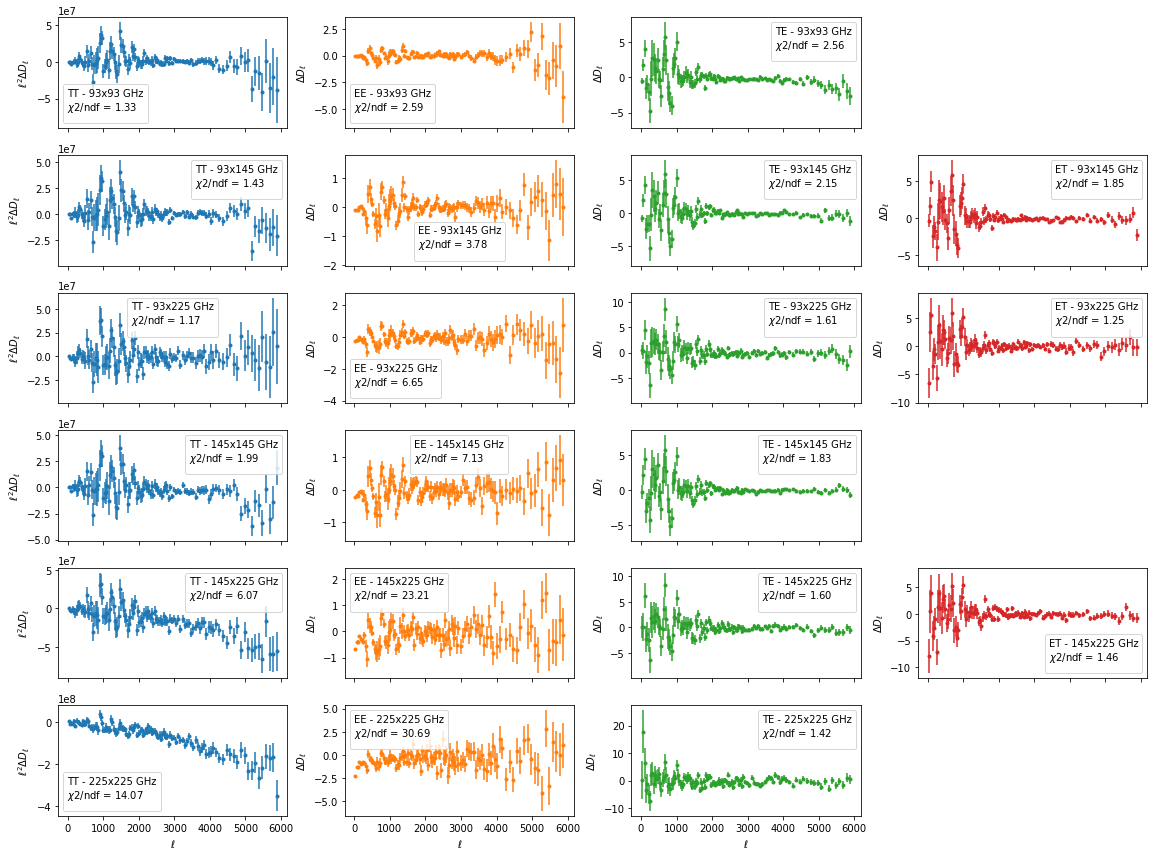

In [70]:
spectra = ["tt", "ee", "te", "et"]
isim = 44

from itertools import combinations_with_replacement as cwr

crosses = list(cwr(freqs, 2))
fig, axes = plt.subplots(len(crosses), 4, sharex=True, figsize=(16, 2 * len(crosses)))
for i, cross in enumerate(crosses):
    for j, spec in enumerate(spectra):
        ax = axes[i, j]
        try:
            cov, bpws = read_sacc_cov(spec, cross)
            inv_cov = np.linalg.inv(cov)
        except:
            # No cov for "ET" and same frequencies
            fig.delaxes(ax)
            continue
        l, cl = read_sacc_data(spec, cross, isim)
        ps_obs = dl_obs[(spec if spec != "et" else "te", cross[0], cross[1])]
        cl_model = np.dot(bpws.weight.T, ps_obs)
        delta_cl = cl - cl_model
        cl_err = np.sqrt(np.diag(cov))
        if spec == "tt":
            ax.errorbar(l, l ** 2 * delta_cl, l ** 2 * cl_err, fmt=".C{}".format(j))
        else:
            ax.errorbar(l, delta_cl, cl_err, fmt=".C{}".format(j))
        chi2 = delta_cl @ inv_cov @ delta_cl
        title = "%s - %dx%d GHz\n$\chi2$/ndf = %.2f" % (spec.upper(), *cross, chi2 / len(delta_cl))
        axes[i, j].legend([], title=title)

for ax in axes[:, 0]:
    ax.set_ylabel(r"$\ell^2\Delta D_\ell$")
for ax in axes[:, 1:].flatten():
    ax.set_ylabel(r"$\Delta D_\ell$")
for ax in axes[-1]:
    ax.set_xlabel(r"$\ell$")
plt.tight_layout()

Notice that here the difference between simulations and the (theory+foreground) spectra with possible systematics is mainly driven by the different foreground model adopted by the code

## Fisher matrix



Even if we do not need priors to compute Fisher matrix, we need to fool `cobaya` in order to change
parameter values. We set the prior values to &plusmn; 10% arround the central value (or to a fixed window for parameters whose default is 0). We need to take care
of `logA` parameter since `cobaya` will sample it but theory module will use the derivative `As` value.



In [71]:
sampled_params = {**cosmo_params,**fg_params, **nuisance_params}.copy()
sampled_params.update(
    {
        k: {"prior": {"min": 0.9 * v, "max": 1.1 * v}}
        for k, v in sampled_params.items()
        if k not in ["logA", "As","bandint_shift_93","bandint_shift_145","bandint_shift_225",
                     "alpha_93","alpha_145","alpha_225"]
    }
)

sampled_params.update(
    {
        k: {"prior": {"min": -0.5, "max": 0.5}}
        for k in sampled_params.keys()
        if k in ["bandint_shift_93","bandint_shift_145","bandint_shift_225",
                     "alpha_93","alpha_145","alpha_225"]
    }
)

sampled_params["logA"] = {
    "prior": {
        "min": 0.9 * cosmo_params["logA"]["value"],
        "max": 1.1 * cosmo_params["logA"]["value"],
    },
    "drop": True,
}

Then we define a new model (after having close the previous one to release memory allocation) and
get the `MFLike` likelihood



In [72]:
model.close()
info = {
    "params": sampled_params,
    "likelihood": mflike_config,
    "theory": {"camb": {"extra_args": {"lens_potential_accuracy": 1}}},
    "packages_path": packages_path,
}

model = get_model(info)
mflike = model.likelihood["mflike.MFLike"]

[CAMB] Importing *auto-installed* CAMB (but defaulting to *global*).
[camb] Initialized!
[mflike.mflike] Initialized!


Given the sampled parameters, we now set the defaults value of parameters in the same order as the
`cobaya`'s one



In [73]:
default_values = {**cosmo_params,**fg_params,**nuisance_params}.copy()
default_values["logA"] = cosmo_params["logA"]["value"]
defaults = {k: default_values[k] for k in model.parameterization.sampled_params().keys()}

and we define the list of Fisher parameters, removing from the list the parameters we don't want to perturb (for example, all the nuisance parameters + `Alens`+`T_d` in this case)



In [74]:
fisher_params = list(defaults.keys())
for p in ["Alens","T_d"]+list(nuisance_params.keys()):
    fisher_params.remove(p)

For each parameter, we will compute the associated power spectra by slightly modifying the central
value of the parameter (&plusmn;&epsilon;). The power spectra is taken from `mflike._get_power_spectra`
given the nuisance parameters and we also need to recompute (if necessary) the theoritical
$C_\ell$s. The Fisher algorithm is then



In [75]:
deriv = {k: None for k in fisher_params}
for i, p in enumerate(fisher_params):
    print(i,p)
    def _get_power_spectra(epsilon):
        point = defaults.copy()
        if point[p] != 0:
            point.update({p: point[p] * (1 + epsilon)})
        else:
            point.update({p: point[p] + epsilon})    
        model.logposterior(point)
        cl = model.theory["camb"].get_Cl(ell_factor=True)
        return mflike._get_power_spectra(cl, **point)

    epsilon = 0.01
    ps_minus = _get_power_spectra(-epsilon)
    ps_plus = _get_power_spectra(+epsilon)
    if defaults[p] != 0:
        delta = (ps_plus - ps_minus) / (2 * epsilon * defaults[p])
    else:
        delta = (ps_plus - ps_minus) / (2 * epsilon)
    if np.all(delta == 0):
        print(
            "WARNING: Sampling a parameter '{}' that do not have "
            "any effect on power spectra! You should remove it from "
            "cobaya parameter dictionary.".format(p)
        )
        fisher_params.remove(p)
        continue
    deriv[p] = delta

nparams = len(fisher_params)
fisher_matrix = np.empty((nparams, nparams))
for i1, p1 in enumerate(fisher_params):
    for i2, p2 in enumerate(fisher_params):
        fisher_matrix[i1, i2] = np.dot(deriv[p1], mflike.inv_cov.dot(deriv[p2]))
fisher_cov = np.linalg.inv(fisher_matrix)

0 cosmomc_theta
1 logA
2 ombh2
3 omch2
4 ns
5 tau
6 a_tSZ
7 a_kSZ
8 a_p
9 beta_p
10 a_c
11 beta_c
12 a_s
13 a_gtt
14 a_gte
15 a_gee
16 a_psee
17 a_pste
18 xi


We can show the correlation matrix between parameters



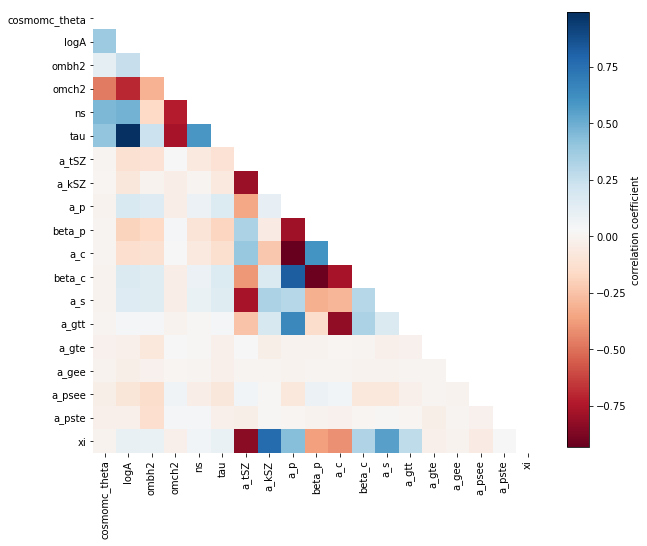

In [76]:
fisher_sigmas = np.sqrt(np.diag(fisher_cov))
norm = np.outer(fisher_sigmas, fisher_sigmas)
fisher_corr = fisher_cov / norm
plt.figure(figsize=(10, 10))
ind = np.triu_indices_from(fisher_corr)
fisher_corr[ind] = np.nan
plt.imshow(fisher_corr, cmap="RdBu")
plt.xticks(np.arange(nparams), fisher_params, rotation=90)
plt.yticks(np.arange(nparams), fisher_params, rotation=0)
cbar = plt.colorbar(shrink=0.8)
cbar.set_label("correlation coefficient")
[s.set_visible(False) for s in plt.gca().spines.values()];

and the Fisher estimated noise



In [77]:
for param_name, param_sigma in zip(fisher_params, fisher_sigmas):
    print(
        "param: {}, sigma: {}, Fisher S/N: {}".format(
            param_name, param_sigma, defaults[param_name] / param_sigma
        )
    )

param: cosmomc_theta, sigma: 1.3914403909697044e-06, Fisher S/N: 7478.7177859253125
param: logA, sigma: 0.01784257750160556, Fisher S/N: 171.3869086304839
param: ombh2, sigma: 6.32017170555071e-05, Fisher S/N: 350.918282497318
param: omch2, sigma: 0.0010839545164564696, Fisher S/N: 111.91222339897098
param: ns, sigma: 0.003115886992972786, Fisher S/N: 308.8327407798273
param: tau, sigma: 0.010079380932155216, Fisher S/N: 5.844297025432918
param: a_tSZ, sigma: 0.07542780185677395, Fisher S/N: 43.750446370771925
param: a_kSZ, sigma: 0.15487576670505065, Fisher S/N: 10.330860883143073
param: a_p, sigma: 0.14422337381551428, Fisher S/N: 47.84245311599942
param: beta_p, sigma: 0.020568132806233964, Fisher S/N: 101.12731279961281
param: a_c, sigma: 0.23497628319962782, Fisher S/N: 20.85316838481579
param: beta_c, sigma: 0.03649419118840407, Fisher S/N: 60.28356646246332
param: a_s, sigma: 0.014808021989300204, Fisher S/N: 209.34598842708093
param: a_gtt, sigma: 0.2553298677716428, Fisher S/N

Let's show the Signal over Noise ratio graphically



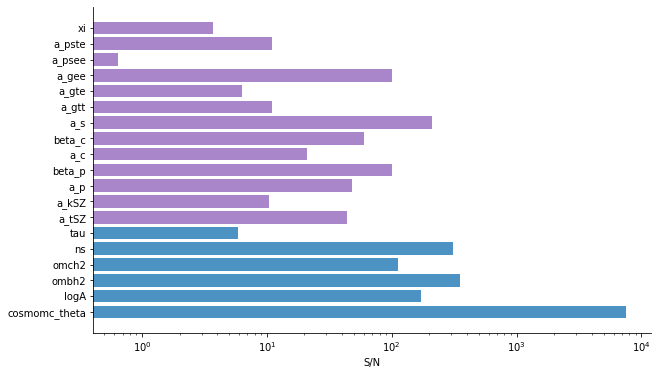

In [78]:
plt.figure(figsize=(10, 6))
SoN = [
    defaults[param_name] / param_sigma
    for param_name, param_sigma in zip(fisher_params, fisher_sigmas)
]
colors = ["tab:blue" if name in cosmo_params else "tab:purple" for name in fisher_params]
plt.barh(np.arange(len(SoN)), SoN, color=colors, alpha=0.8)
plt.xscale("log")
plt.xlabel("S/N")
plt.yticks(range(len(fisher_params)), fisher_params)
plt.gca().spines["right"].set_color(None)
plt.gca().spines["top"].set_color(None)

It also works for TT, TE or EE mode even if you keep the default list of sampled parameters. It will
only warn you about the fact that some parameters have no effect on power spectra and thus can be
removed from the sampled parameter list.



## Using the MFLike likelihood without cobaya



The `MFLike` likelihood can also be used independently of `cobaya`. The principle is the same as in
this `cobaya`'s [example](https://github.com/CobayaSampler/planck_lensing_external). First we need
to instantiate an `MFLike` object



In [79]:
from mflike import MFLike

my_mflike = MFLike(
    {
        "packages_path": packages_path,
        "input_file": "data_sacc_00044.fits",
        "cov_Bbl_file": "data_sacc_w_covar_and_Bbl.fits",
    }
)

[mflike] Initialized!


To compute the log-likelihood value, we can use the `loglike` function which takes as parameters an
theoretical $C_\ell$ dictionary and the nuisance parameter values. The $C_\ell$ dictionary can be,
for instance, retrieved from an independant program or an independant computation. Here we will use
`CAMB` to compute the $C_\ell$ from a cosmological model set by the `cosmo_params`



In [80]:
camb_cosmo = {k: v for k, v in cosmo_params.items() if k not in ["logA", "As"]}
camb_cosmo.update(
    {
        "As": 1e-10 * np.exp(cosmo_params["logA"]["value"]),
        "lmax": mflike.lmax_theory+1,
        "lens_potential_accuracy": 1,
    }
)

pars = camb.set_params(**camb_cosmo)
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit="muK")
cl_dict = {k: powers["total"][:, v] for k, v in {"tt": 0, "ee": 1, "te": 3, "bb": 2}.items()}

Let's plot $C_\ell$ and let's compare them to the ones from `cobaya`



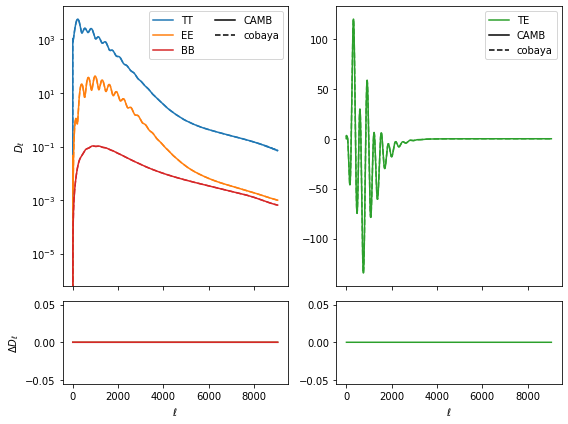

In [81]:
fig = plt.figure(figsize=(8, 6))
gs = plt.GridSpec(4, 2)
axes = {
    "tt": [fig.add_subplot(gs[0:3, 0], xticklabels=[]), fig.add_subplot(gs[-1, 0])],
    "te": [fig.add_subplot(gs[0:3, 1], xticklabels=[]), fig.add_subplot(gs[-1, 1])],
}

l = np.arange(cl_dict["tt"].shape[0])
for i, (k, v) in enumerate(cl_dict.items()):
    plot = axes["te"][0].plot if k == "te" else axes["tt"][0].semilogy
    plot(l, v, "-C{}".format(i), label=k.upper())
    plot(l, Dls[k], "--C{}".format(i))
    ax = axes["te"][1] if k == "te" else axes["tt"][1]
    ax.plot(l, v - Dls[k], "-C{}".format(i))

axes["tt"][0].set_ylabel(r"$D_\ell$")
axes["tt"][1].set_ylabel(r"$\Delta D_\ell$")
for k in axes.keys():
    axes[k][1].set_xlabel(r"$\ell$")
    axes[k][0].plot([], [], "-k", label="CAMB")
    axes[k][0].plot([], [], "--k", label="cobaya")
    axes[k][0].legend(ncol=1 if k == "te" else 2)
plt.tight_layout()

Now we can inject these $C_\ell$ into the `loglike` function to get the corresponding log-likelihood
value



In [82]:
loglike = my_mflike.loglike(cl_dict, **fg_params,**nuisance_params)
print("log-likelihood value =", loglike)
print("Χ² value =", -2 * (loglike - mflike.logp_const))

log-likelihood value = -8110.904185733497
Χ² value = 15841.4752586473
